Naive Bayes on Amazon Food review dataset

Naive Bayes is an supervied machine learning algorithm that can be used to predict polarity of reviews in amazon fine foods dataset obtained from kaggle. (https://www.kaggle.com/snap/amazon-fine-food-reviews)

In this ipython notebook,following steps are performed:
    1. Loading cleaned and pre-processed data 
    2. Sample data based on timestamp
    3. Convert text to vector using one of the following methods
        a.bag of words
        b.tf-idf
        c.average word2vec
        d.tf-idf word2vec
    4. Apply Naive Bayes
        a. normalise data
        b. divide data into test and train
        c. find the optimal L using 10-fold cross validation
        d. use Naive bayes algorithm to predict polarity
    5. Performance measurement
        a. accuracy
        b. confusion matrix
        c. presicion, recall and f1-score
    6. Find feature importance

1. Load data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Using sqlite3 to retrieve data from sqlite file
con = sqlite3.connect(r'C:\Users\Admin\Downloads\final.sqlite')

#Read data from the sqlite file
data = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)



2.Sample Data

In [2]:
data.sort_values('Time',inplace=True,ascending=False)
#sampled_data = cleaned_data.sample(frac=0.275,random_state=1), time series split function can also be used.
sampled_data=data[0:12000]

Divide data into test and train

In [3]:
#We use 70% of data for training and 30% of data for test
import math
sampled_data.sort_values('Time',inplace=True,ascending=True) 

X_train =  sampled_data[:math.ceil(len(sampled_data)*.7)] 
X_test = sampled_data[math.ceil(len(sampled_data)*.3):]
y_train = sampled_data['Score'][:math.ceil(len(sampled_data)*.7)]
y_test =  sampled_data['Score'][math.ceil(len(sampled_data)*.3):]

3.Convert Text to vector

Bag of Words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
bow_model = count_vect.fit(X_train['CleanedText'])
final_bow_train = bow_model.transform(X_train['CleanedText'])
final_bow_test = bow_model.transform(X_test['CleanedText'])

4.Apply Naive Bayes

a. Standardise data

In [5]:
from sklearn.preprocessing import StandardScaler

normalised_bow_train = StandardScaler(with_mean=False).fit_transform(final_bow_train)
normalised_bow_test = StandardScaler(with_mean=False).fit_transform(final_bow_test)

b. Find optimal l

In [7]:
from sklearn import cross_validation
from sklearn.metrics import accuracy_score

def find_optimal_l(X_train,y_train, lvalues):
   
    # empty list that will hold cv scores
    posterior = []

    # split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

    for i in lvalues:
        nb = MultinomialNB(alpha = i)
        model = nb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = model.predict(X_cv)

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, pred, normalize=True)
        posterior.append(acc)
        
    # changing to misclassification error
    error = [1 - x for x in posterior]

    # determining best alpha
    optimal_alpha = lvalues[error.index(min(error))]
    print('\nThe optimal alpha is ', optimal_alpha)
  
    sns.set_style("darkgrid")
    plt.plot(lvalues,error)
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.title("Accuracy for different alpha values")
    plt.show()
    
    
      
    return optimal_alpha


The optimal alpha is  1e-05


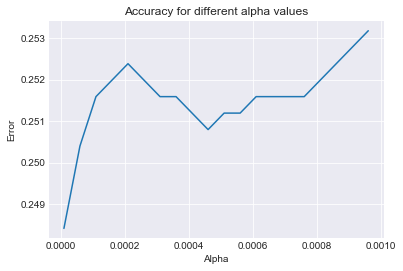

In [8]:
from sklearn.naive_bayes import MultinomialNB

lvalues = np.arange(0.00001, 0.001, 0.00005)
optimal_l = find_optimal_l(normalised_bow_train ,y_train,lvalues)

d. Apply naive bayes

In [9]:
naivebayes = MultinomialNB(alpha = optimal_l)
model = naivebayes.fit(normalised_bow_train, y_train)

In [10]:
predicted = (model.predict(normalised_bow_test))

5.Performance measurements

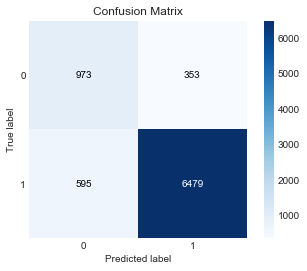

In [11]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,predicted)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [13]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 88.714%
Precision on test set: 0.948
Recall on test set: 0.916
F1-Score on test set: 0.932


6.Determine feature importance

In [14]:
features = count_vect.get_feature_names()

In [15]:
imp_features= pd.DataFrame(model.feature_log_prob_,columns=features)
imp_features_transposed = imp_features.T

In [16]:
neg_features=imp_features_transposed[0].sort_values(ascending = False)
pos_features=imp_features_transposed[1].sort_values(ascending = False)

In [17]:
print("Top ten negative features:")
neg_features.head(10)

Top ten negative features:


product      -6.291803
tast         -6.294553
disappoint   -6.337669
like         -6.410657
would        -6.416314
return       -6.476211
order        -6.630047
money        -6.630802
buy          -6.649779
tri          -6.658869
Name: 0, dtype: float64

In [18]:
print("Top ten positive features:")
pos_features.head(10)

Top ten positive features:


love     -6.272990
great    -6.302776
good     -6.348003
like     -6.433765
tast     -6.490315
use      -6.551681
flavor   -6.557062
tri      -6.560582
one      -6.573515
make     -6.635798
Name: 1, dtype: float64

Tf-Idf

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer()
tfidf_model = tf_idf_vec.fit(X_train['CleanedText'])
final_tfidf_train = tfidf_model.transform(X_train['CleanedText'])
final_tfidf_test = tfidf_model.transform(X_test['CleanedText'])

In [20]:
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(final_tfidf_test)


The optimal alpha is  1e-05


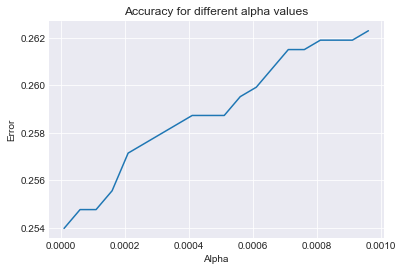

In [21]:
lvalues = np.arange(0.00001, 0.001, 0.00005)

optimall = find_optimal_l(normalised_tfidf_train ,y_train,lvalues)

In [22]:
naivebayes = MultinomialNB(alpha = optimall)
model = naivebayes.fit(normalised_tfidf_train, y_train)

In [23]:
predicted = (model.predict(normalised_tfidf_test))

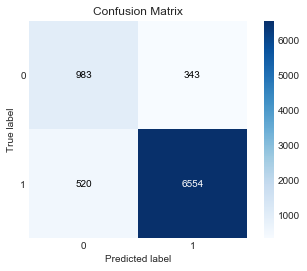

In [24]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [25]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 89.726%
Precision on test set: 0.950
Recall on test set: 0.926
F1-Score on test set: 0.938


In [26]:
features =tf_idf_vec.get_feature_names()

In [27]:
imp_features= pd.DataFrame(model.feature_log_prob_,columns=features)
imp_features_transposed = imp_features.T

In [28]:

neg_features=imp_features_transposed[0].sort_values(ascending = False)
pos_features=imp_features_transposed[1].sort_values(ascending = False)

In [29]:
print("Top ten negative features:")
neg_features.head(10)

Top ten negative features:


tast         -6.219278
product      -6.277438
disappoint   -6.323972
like         -6.324557
would        -6.376995
return       -6.411733
money        -6.575754
dont         -6.633569
didnt        -6.659993
wast         -6.662811
Name: 0, dtype: float64

In [30]:
print("Top ten positive features:")
pos_features.head(10)

Top ten positive features:


love      -6.282649
great     -6.349071
like      -6.360697
good      -6.363956
tast      -6.410228
use       -6.468792
flavor    -6.473943
tri       -6.509070
one       -6.509089
product   -6.536840
Name: 1, dtype: float64

Avg word2vec

In [31]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [32]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [33]:
i=0
str1=''
list_of_sent_train=[]
final_string_for_tfidf_train = []
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent_train.append(filtered_sentence)
    final_string_for_tfidf_train.append((str1).strip())

In [34]:
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [35]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

In [36]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [37]:
X_train = sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [38]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
minmax_w2v_train = scaler.fit_transform(X_train)
minmax_w2v_test = scaler.fit_transform(X_test)


The optimal alpha is  1e-05


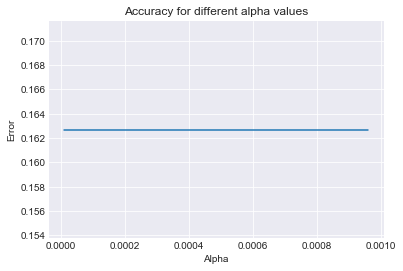

In [40]:
lvalues = np.arange(0.00001, 0.001, 0.00005)

optimall = find_optimal_l(minmax_w2v_train ,y_train,lvalues)

In [41]:
naivebayes = MultinomialNB(alpha = optimall)
model = naivebayes.fit(minmax_w2v_train, y_train)

In [42]:
predicted = (model.predict(minmax_w2v_test))

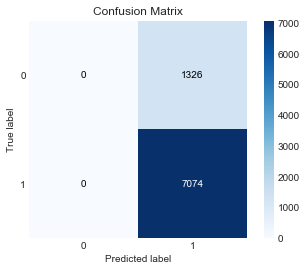

In [43]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [44]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.214%
Precision on test set: 0.842
Recall on test set: 1.000
F1-Score on test set: 0.914


tf-idf avg w2v

In [45]:
tf_idf_w2v = TfidfVectorizer()
tfidf_model = tf_idf_w2v.fit(final_string_for_tfidf_train)
final_tfidf_w=tfidf_model.transform(final_string_for_tfidf)

In [46]:
tfidf_feat = tf_idf_w2v.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [47]:
X_train = tfidf_sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test =tfidf_sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [48]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
minmax_tfidfw2v_train = scaler.fit_transform(X_train)
minmax_tfidfw2v_test = scaler.fit_transform(X_test)


The optimal alpha is  1e-05


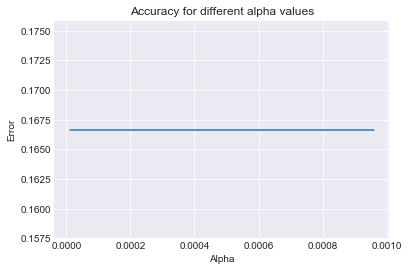

In [50]:
lvalues = np.arange(0.00001, 0.001, 0.00005)

optimall = find_optimal_l(minmax_tfidfw2v_train ,y_train,lvalues)

In [51]:
naivebayes = MultinomialNB(alpha = optimall)
model = naivebayes.fit(minmax_tfidfw2v_train, y_train)

In [52]:
predicted = (model.predict(minmax_tfidfw2v_test))

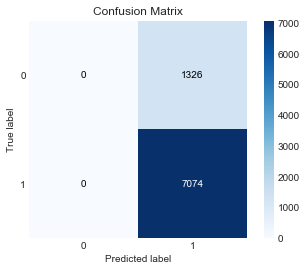

In [53]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [54]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 84.214%
Precision on test set: 0.842
Recall on test set: 1.000
F1-Score on test set: 0.914
